# Generative models tutorial

In generative modelling, we have a dataset sampled from a probability distribution $X \sim P(X)$. We want to learn a model which can approximate this distribution.

In latent variable models, we assume that the factors of variation of the data are explained by hidden (latent) variables $Z$. At inference time, we can sample values of $Z$ and generate data by using our model to predict $P(X \vert Z)$.

First, create a dataset. We use the two moons dataset. 

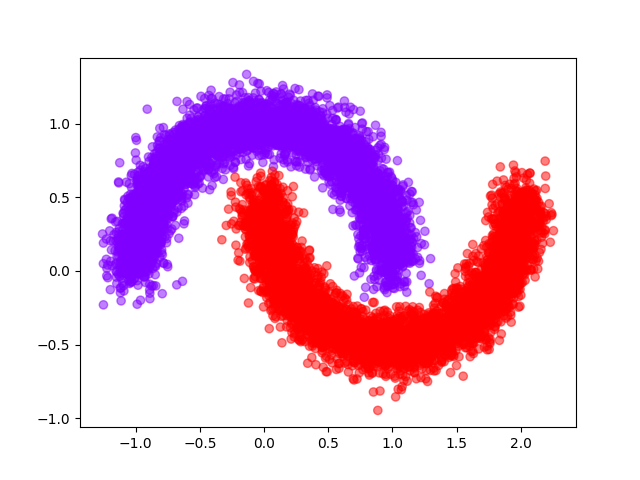

In [14]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as datasets
import torch
from torch.utils.data import DataLoader, Dataset, random_split

# we save images to outputs/ and read them instead of displaying them directly,
# this helps fix a matplotlib bug when doing live colla
os.makedirs("outputs", exist_ok=True)


class MoonsDataset(Dataset):
    def __init__(self, n_samples=10000, noise=0.1):
        X, y = datasets.make_moons(n_samples=10000, noise=0.1)
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray)

        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


ds = MoonsDataset()
n_train, n_val, n_test = 6000, 2000, 2000
train_ds, val_ds, test_ds = random_split(ds, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

plt.scatter(ds.X[:, 0], ds.X[:, 1], c=ds.y, cmap="rainbow", alpha=0.5)
plt.savefig("outputs/moons.png")
plt.close()
Image.open("outputs/moons.png").show()


## GAN Implementation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class Generator(nn.Module):
    def __init__(self, latent_dim: int = 128, output_dim: int = 2) -> None:
        super().__init__()

        def block(in_features: int, out_features: int):
            return nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.BatchNorm1d(out_features),
                nn.LeakyReLU(inplace=True),
            )
        
        self.model = nn.Sequential(
            block(latent_dim, 256),
            block(256, 512),
            block(512, 1024),
            nn.Linear(1024, output_dim),
            nn.Tanh(),
        )
    
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, input_dim: int = 2) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

class MoonsGAN(pl.LightningModule):
    def __init__(self, latent_dim: int = 128, lr: float = 3e-4) -> None:
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(self.hparams.latent_dim) # type: ignore
        self.discriminator = Discriminator(input_dim=2)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.generator(z)

    def adversarial_loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        X, _ = batch
        z = torch.randn(X.shape[0], self.hparams.latent_dim) # type: ignore
        z = z.type_as(X)

        
